# 1 简介
新用户流失的问题在这些游戏中依然严重，大量新用户在试玩不久后就选择放弃。如果能在用户彻底卸载游戏之前对可能流失的用户进行有效干预，比如赠送游戏道具或发送鼓励的消息，就有可能挽留住他们，进而提升游戏的活跃度和公司的潜在利润。因此，预测用户流失已经成为一个极具挑战性的重要问题。
我们将以真实游戏的非结构化日志数据为出发点，构建一个用户流失预测模型，并根据已有知识设计合适的算法来解决实际问题。

In [1]:
# train.csv  test.csv  dev.csv
# 分别对应训练集 测试集 验证集
# 分别是 userid 和 对应的流失情况，如果为1表示流失 如果为0表示没流失
import pandas as pd

train_df = pd.read_csv("train.csv",sep="\t")
print(train_df.head())
print(train_df.shape)
test_df = pd.read_csv("test.csv",sep="\t")
print(test_df.head())
print(test_df.shape)
dev_df = pd.read_csv("dev.csv",sep="\t")
print(dev_df.head())
print(dev_df.shape)

   user_id  label
0     2774      0
1     2775      0
2     2776      1
3     2777      0
4     2778      1
(8158, 2)
   user_id
0        1
1        2
2        3
3        4
4        5
(2773, 1)
   user_id  label
0    10932      0
1    10933      1
2    10934      0
3    10935      1
4    10936      0
(2658, 2)


In [ ]:
# level_seq.csv 包含每个用户在每个关卡中的一些数据
# 包括f_success 表示通关 1 表示通关 0 表示没通关
# f_duration 表示所用的时间
# f_reststep 表示剩余步数和游戏限定步数之比
# f_help 表示是否使用道具提示等 1 表示使用 0表示未使用
# time 表示这个游戏打开时的时间戳

In [3]:
seq_df = pd.read_csv("level_seq.csv",sep="\t")
seq_df.describe()

,user_id,level_id,f_success,f_duration,f_reststep,f_help
count,2.194351e+06,2.194351e+06,2.194351e+06,2.194351e+06,2.194351e+06,2.194351e+06
mean,6.745030e+03,9.683600e+01,5.283216e-01,1.081228e+02,1.678471e-01,4.415565e-02
std,3.942094e+03,8.410689e+01,4.991974e-01,5.361323e+01,2.261460e-01,2.054409e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.287000e+03,4.100000e+01,0.000000e+00,7.700000e+01,0.000000e+00,0.000000e+00
50%,6.688000e+03,8.000000e+01,1.000000e+00,1.000000e+02,4.545455e-02,0.000000e+00
75%,1.016300e+04,1.420000e+02,1.000000e+00,1.270000e+02,2.857143e-01,0.000000e+00
max,1.358900e+04,1.509000e+03,1.000000e+00,6.000000e+02,1.000000e+00,1.000000e+00


In [ ]:
# level_meta.csv
# f_avg_duration 平均花费时间	f_avg_passrate 平均通关率   f_avg_win_duration  平均每次通关花费的时间
# f_avg_retrytimes	 平均重试次数  level_id 关卡的id  可与seq对应

In [4]:
meta_df = pd.read_csv("level_meta.csv",sep="\t")
meta_df.describe()

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000
mean,514.408527,0.445386,116.009104,3.421754,755.000000
std,234.731711,0.190031,27.655346,4.068877,435.755092
min,39.889940,0.000000,35.582757,0.000000,1.000000
25%,372.250000,0.334503,101.239606,2.000000,378.000000
50%,497.652174,0.402935,112.666667,3.291613,755.000000
75%,623.587065,0.509404,126.443548,4.406417,1132.000000
max,2105.000000,1.000000,540.000000,98.000000,1509.000000


# 2 数据预处理
第一步选择特征工程：


从以下几个维度进行特征工程，刻画不同用户：
- 是否喜欢：
    - `login`：登录次数。 
    - `time`：游戏总花费的时间
    - `try`：尝试记录次数
- 游玩体验：
    - `success`：通关数/尝试次数
    - `maxlevel`：最大闯关数
    - `maxwin`：最大连赢数 
    - `maxfail`：最大连输数
    - `winof20`：最后20局的胜率  
- 个人特性：
    - `beginday`：开始玩的时间 
    - `help`：使用帮助的频率 
    - `retry`：最大愿意重试的次数
    - `duration`：平均每一关超出平均时长
    - `restep`：成功通关的记录中，平均剩余步数与限定步数之比

In [5]:
from datetime import datetime

def cvttime(data):
    data,time = str(data).split()
    year,month,day = map(int,data.split("-"))
    hour,minute,second = map(int,time.split(":"))
    return datetime(year,month,day,hour,minute,second)


In [6]:
# .map()方法的参数中指定一个函数，该函数将被应用于列中的每个元素，以实现映射转换的逻辑
seq_df["time"] = seq_df["time"].map(lambda x: cvttime(x))

# 计算平均每次花费的时间
f_avg = meta_df["f_avg_duration"].values

# 计算用户的游戏时长和所有人平均游戏的平均时长的差距
# apply应用一个函数到DataFrame的每一行或每一列
seq_df["avg_time"] = seq_df.apply(lambda x:x["f_duration"] - f_avg[int(x["level_id"]-1)],axis=1)

print(seq_df.head())

   user_id  level_id  f_success  f_duration  f_reststep  f_help  \
0    10932         1          1       127.0    0.500000       0   
1    10932         2          1        69.0    0.703704       0   
2    10932         3          1        67.0    0.560000       0   
3    10932         4          1        58.0    0.700000       0   
4    10932         5          1        83.0    0.666667       0   

                 time   avg_time  
0 2020-02-01 00:05:51  87.110060  
1 2020-02-01 00:08:01   8.316025  
2 2020-02-01 00:09:50  -9.947355  
3 2020-02-01 00:11:16  -0.170347  
4 2020-02-01 00:13:12 -18.784577  


In [10]:
def cal_login(series):
    # 计算用户的登录次数
    ans = 1
    # 如果 两次登录时间间隔大于900s 则认为是两次登录
    for start,end in zip(*[iter(series)]*2):
        if(end-start).total_seconds() > 900:
            ans+=1
    
    return ans


In [11]:
def cal_fail_retry(df):
    # 连败
    fail_series = df["f_success"].eq(0)
    fail_counts = fail_series.groupby((fail_series!=fail_series.shift()).cumsum()).cumsum()
    max_fail = fail_counts.max()
    # 连赢
    win_series = df["f_success"].eq(1)
    win_counts = win_series.groupby((win_series!=win_series.shift()).cumsum()).cumsum()
    max_win = win_counts.max()
    # 重试的最大次数
    retry_series = df["level_id"]
    retry_counts = retry_series.groupby((retry_series!=retry_series.shift()).cumsum()).cumcount()
    max_retry = retry_counts.max()
    return max_win,max_fail,max_retry


In [52]:
import numpy as np
from tqdm import tqdm

user_df = seq_df.groupby("user_id")
# 初始化训练集、验证集和测试集的 X 和 y
train_X, valid_X, test_X = [], [], []
train_y, valid_y, test_y = [], [], []

for user_id,df in tqdm(user_df):
    user = []
    # 统计用户登录次数
    login = cal_login(df["time"])
    user.append(login)
    # 计算总的游戏时长
    user.append(sum(df["f_duration"]))
    # 计算总尝试次数
    try_sum = df.shape[0]
    user.append(try_sum)

    # 计算游戏体验
    # 计算用户平均成功率
    user.append(np.nanmean(df["f_success"]))
    #  计算最高关卡id
    user.append(max(df["level_id"]))
    # 计算最大连胜次数
    win,fail,retry = cal_fail_retry(df)
    user.append(win)
    user.append(fail)
    # 最近20场的胜率
    user.append(np.nanmean(df["f_success"][-20 if try_sum >=20 else 0:]))

    # 个人特性
    # 平均求助次数
    user.append(np.nanmean(df["f_help"]))
    # 最大求助次数
    user.append(retry)
    # 与平均游戏时长的差距
    user.append(np.nanmean(df["avg_time"]))
    # 计算用户成功时的平均剩余步数
    if not df[df["f_success"]==1].shape[0]:
        user.append(0)
    else:
        user.append(np.nanmean(df[df["f_success"]==1]["f_reststep"]))
    
    if user_id in set(train_df["user_id"]):
        train_X.append(user)
        train_y.append(train_df[train_df["user_id"]==user_id]["label"])
    elif user_id in set(dev_df['user_id']):  # 如果用户在验证集中
        valid_X.append(user)
        valid_y.append(dev_df[dev_df['user_id'] == user_id]['label'])
    else:  # 如果用户在测试集中
        test_X.append(user)


100%|██████████| 13589/13589 [00:32<00:00, 412.69it/s]


In [54]:
train_X, valid_X, test_X = np.array(train_X), np.array(valid_X), np.array(test_X)
train_y, valid_y, test_y = np.array(train_y), np.array(valid_y), np.array(test_y)
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

feature_df = pd.DataFrame(np.concatenate((train_X, train_y),axis =1), columns=[ 'login',  'time', 'try', 'success', 'maxlevel', 'maxwin', 'maxfail', 'winof20', 'help', 'retry', 'duration', 'restep', 'label'])
feature_df.describe()


(8158, 12) (8158, 1)
(2658, 12) (2658, 1)
(2773, 12) (0,)


,login,time,try,success,maxlevel,maxwin,maxfail,winof20,help,retry,duration,restep,label
count,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.00000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000
mean,5.455994,17479.688772,161.776538,0.673581,129.745894,20.357195,7.17443,0.528459,0.044279,7.366144,-103.787820,0.322834,0.334641
std,4.109535,19474.149335,184.456500,0.192768,113.298225,28.268813,11.03897,0.269326,0.040586,12.865756,108.102283,0.091907,0.471894
min,1.000000,22.000000,2.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-822.308533,0.000000,0.000000
25%,2.000000,4332.000000,44.000000,0.528976,39.000000,12.000000,2.00000,0.300000,0.013699,2.000000,-145.989994,0.253997,0.000000
50%,4.000000,11737.500000,107.000000,0.680000,122.000000,17.000000,5.00000,0.500000,0.038710,5.000000,-72.764288,0.300037,0.000000
75%,7.000000,24300.250000,211.000000,0.827586,178.000000,24.000000,9.00000,0.750000,0.065273,9.000000,-27.431674,0.375638,1.000000
max,31.000000,534421.000000,4122.000000,1.000000,1509.000000,1675.000000,394.00000,1.000000,0.796875,426.000000,342.713043,0.777778,1.000000


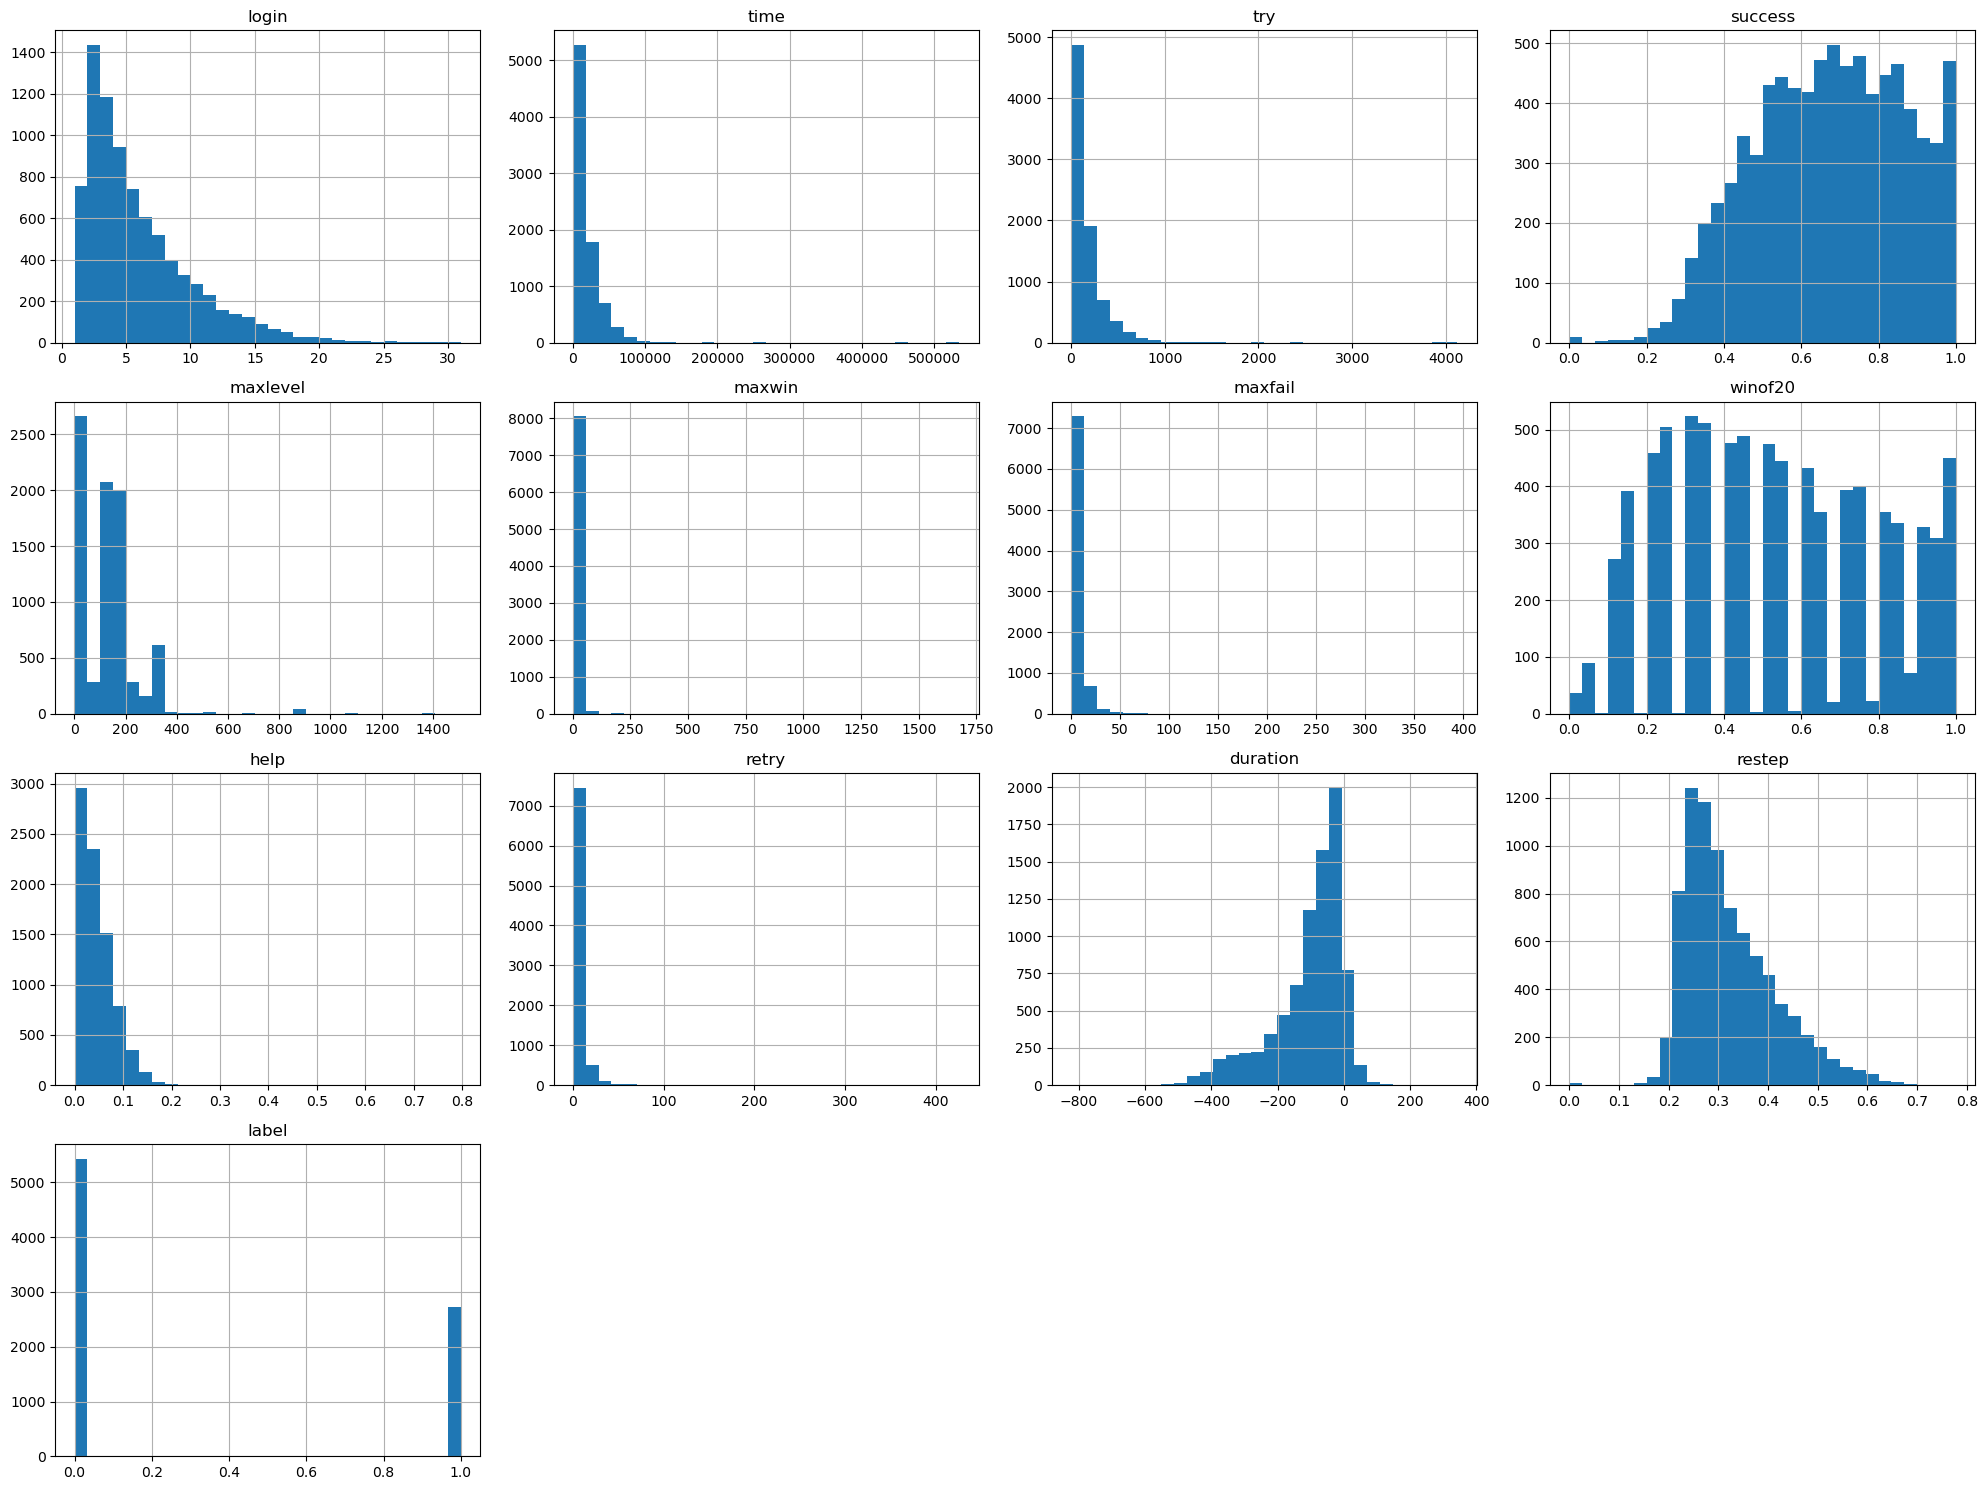

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# hist()方法对DataFrame中的所有列进行直方图绘制
feature_df.hist(bins=30,figsize=(20,15))
plt.tight_layout()
plt.show()

In [56]:
nan_count = np.isnan(feature_df).sum()

print("train_x中NaN值的数量:", nan_count)

train_x中NaN值的数量: login       0
time        0
try         0
success     0
maxlevel    0
maxwin      0
maxfail     0
winof20     0
help        0
retry       0
duration    0
restep      0
label       0
dtype: int64


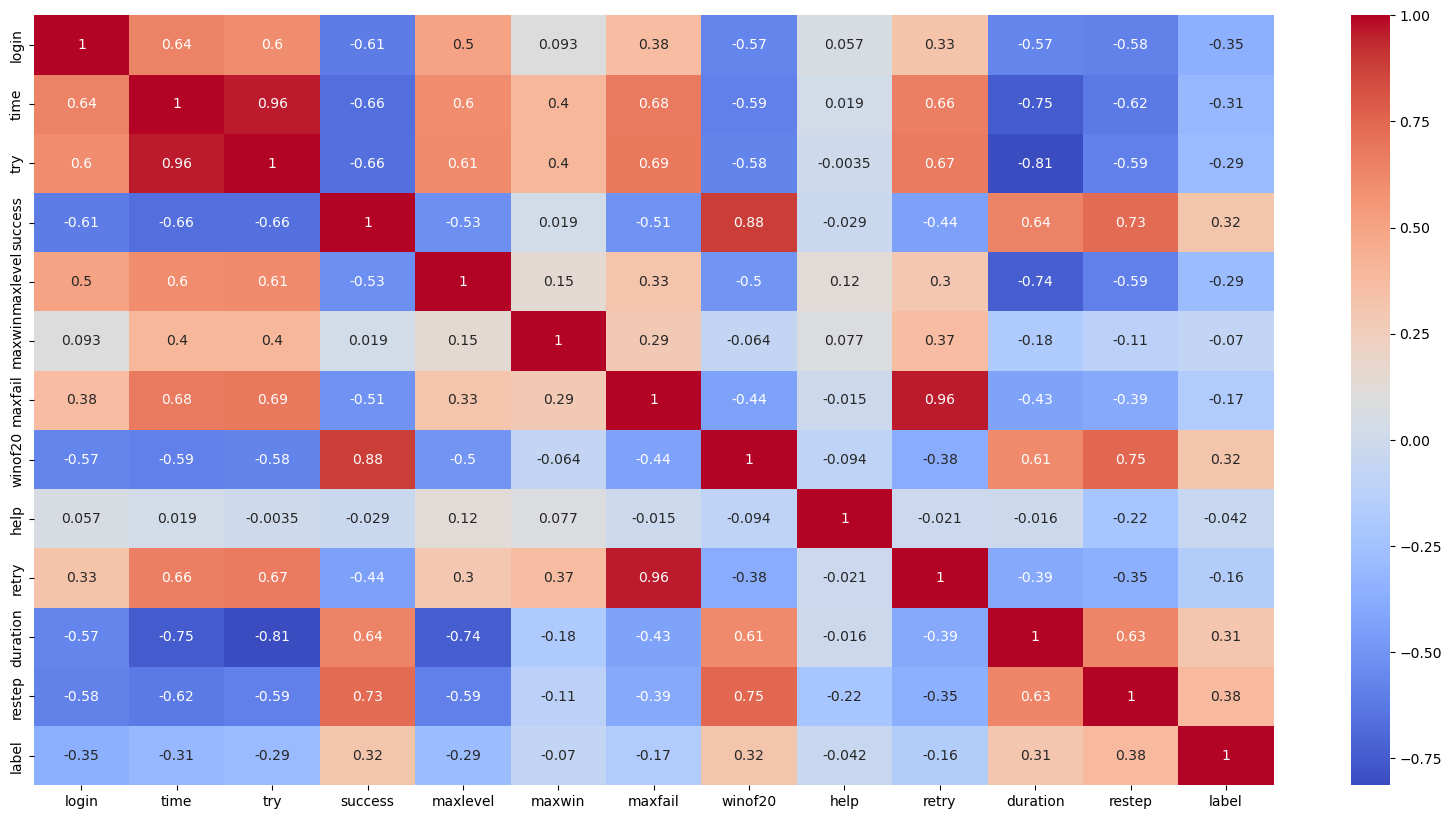

In [57]:
# 计算相关性
corr_matrix = feature_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm")
plt.show()

In [58]:
# 热力图 可以考虑去掉相关性较高的变量。
# time和try有较强的相关性  maxfail和retry有较强的相关性  最后20把的胜率和总体胜率有较强的相关性
# 考虑删除大于0.9
row_indices, col_indices = np.where(np.abs(corr_matrix) >= 0.90)
col_set= set()
for row, col in zip(row_indices, col_indices):
    if row != col:
        col_set.add(corr_matrix.columns[col])
col_list = list(col_set)   
for i in range(len(col_list)):
    if i % 2==0:
        feature_df = feature_df.drop(col_list[i],axis=1)

In [59]:
# 不考虑删除和结果关系较小的，比如最大连胜和帮助，因为可能存在非线性关系  根据经验来看 也不能删除
feature_df.head()

,login,try,success,maxlevel,maxwin,maxfail,winof20,help,duration,restep,label
0,6.0,215.0,0.632558,134.0,20.0,10.0,0.30,0.083721,-136.292257,0.265700,0.0
1,9.0,111.0,0.738739,116.0,13.0,5.0,0.55,0.126126,-19.240214,0.305587,0.0
2,7.0,69.0,0.637681,123.0,12.0,10.0,0.25,0.014493,-100.145530,0.292533,1.0
3,16.0,286.0,0.506993,164.0,18.0,12.0,0.10,0.013986,-178.666781,0.245062,0.0
4,10.0,162.0,0.672840,122.0,19.0,18.0,0.40,0.055556,-36.235551,0.324443,1.0


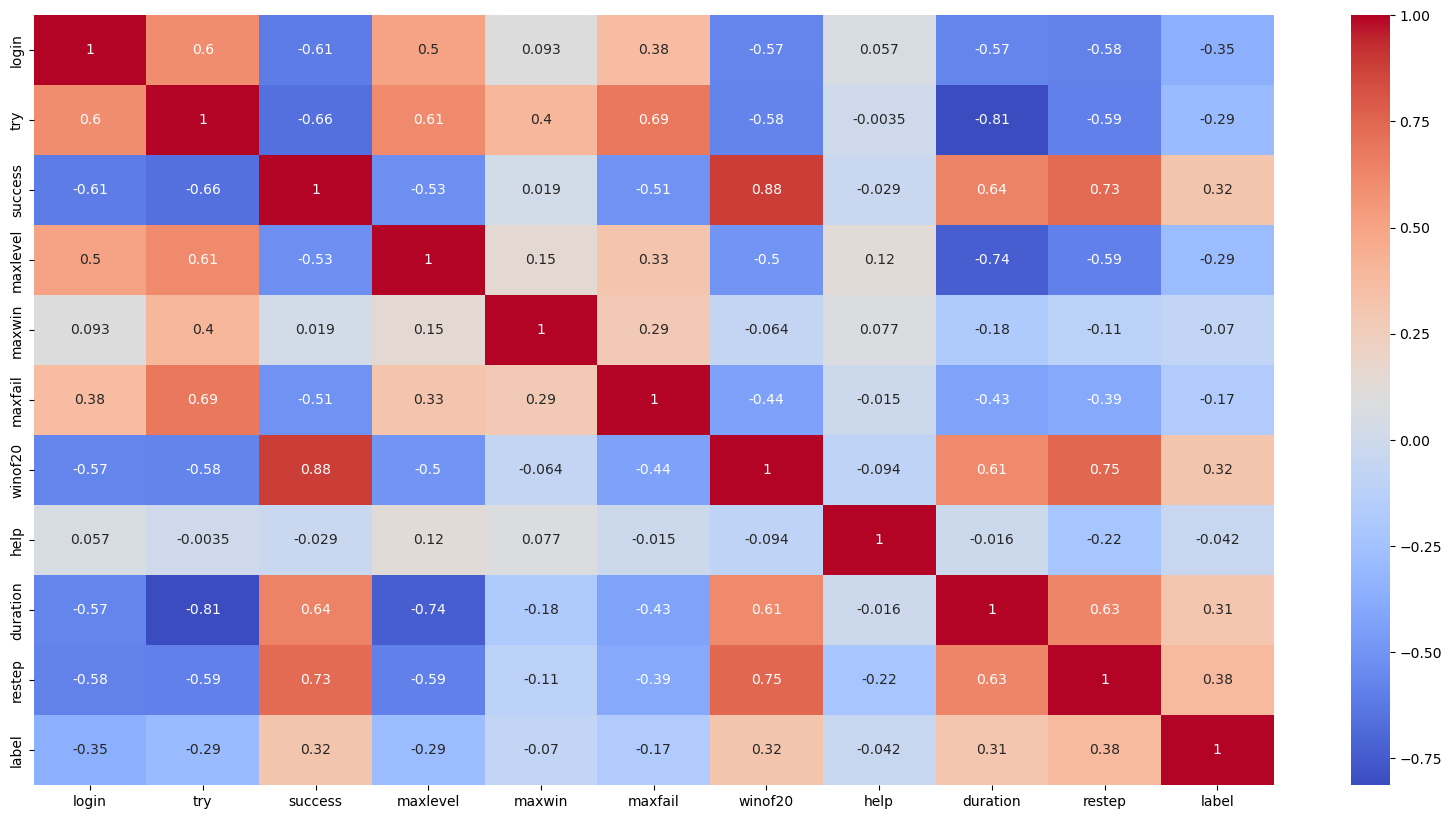

In [60]:
corr_matrix = feature_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm")
plt.show()

In [61]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x = np.array(scaler.fit_transform(train_X))
valid_x = np.array(scaler.transform(valid_X))
test_x = np.array(scaler.transform(test_X))

# 3 模型搭建和训练

In [80]:
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import calibration 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#CalibratedClassifierCV对LinearSVC进行校准，以获得概率输出
models = {
    "LinearSVM":calibration.CalibratedClassifierCV(svm.LinearSVC(loss="squared_hinge",dual=False)),
    "DecisionTree":tree.DecisionTreeClassifier(),
    "GaussianNB":GaussianNB(),
    "MultBayes":MultinomialNB(),
    "Knn":KNeighborsClassifier()
}

In [81]:
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

for name,clf in models.items():
    bcclf = BaggingClassifier(estimator=clf,n_estimators=50,max_samples=0.7,max_features=0.7,bootstrap=True,bootstrap_features=True,n_jobs=1,random_state=42)

    bcclf.fit(train_x,train_y.flatten())
    pre = [x[1] for x in bcclf.predict_proba(valid_x)]
    fpr,tpr,thresholds = metrics.roc_curve(valid_y.flatten(),pre,pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("Bagging auc", name, auc)

    if name!="Knn":
        adclf = AdaBoostClassifier(estimator=clf,n_estimators=30,learning_rate=1,algorithm="SAMME.R")
        adclf.fit(train_x,train_y.flatten())
        pre = [x[1] for x in adclf.predict_proba(valid_x)]
        fpr, tpr, thresholds = metrics.roc_curve(
            valid_y.flatten(), pre, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        print("Boosting auc", name, auc)

    print()


Bagging auc LinearSVM 0.7558224372211488
Boosting auc LinearSVM 0.7494562735264745

Bagging auc DecisionTree 0.7437375912554002
Boosting auc DecisionTree 0.5925222528310731

Bagging auc GaussianNB 0.7425291698277446
Boosting auc GaussianNB 0.646366492173055

Bagging auc MultBayes 0.7529109817271267
Boosting auc MultBayes 0.7399392441333446

Bagging auc Knn 0.7597205912358178

